# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Transformer

### Using transformer

In [11]:
from official.nlp.modeling.models import TransformerEncoder
from official.nlp.configs import encoders

# # Configuration for the Transformer encoder
# encoder_config = encoders.TransformerEncoderConfig(
#     vocab_size=30522,  # Use a large enough vocab size if working with tokenized text; adjust if needed
#     hidden_size=128,  # Example hidden size
#     num_layers=2,  # Example number of layers
#     num_attention_heads=4,  # Example number of attention heads
#     intermediate_size=512,  # Size of the feed-forward network's intermediate layer
#     activation="gelu",
#     dropout_rate=0.1,
#     attention_dropout_rate=0.1,
#     max_sequence_length=512,  # Max length of input sequences
#     type_vocab_size=2,
# )

import keras

@keras.saving.register_keras_serializable()
class ArrayToBooleanModel(keras.Model):
    def __init__(self, **kwargs):
        super(ArrayToBooleanModel, self).__init__(**kwargs)
        self.transformer_encoder = TransformerEncoder(
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            # max_sequence_length=max_sequence_length,
            # vocab_size=vocab_size,
        )
        self.pooling = keras.layers.GlobalAveragePooling1D()
        self.dense = keras.layers.Dense(
            1, activation="sigmoid"
        )  # Output a single boolean value

    def call(self, inputs, training=False):
        x = self.transformer_encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.dense(x)
        return x


def createTransformerModel(timeSteps, features):
    from tensorflow.keras.optimizers import Adam
    model = ArrayToBooleanModel()

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

createTransformerModel(12, 21).summary(expand_nested=True)

2024-08-30 18:11:45.890684: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 18:11:45.898108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 18:11:45.904889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 18:11:45.907289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 18:11:45.914091: I tensorflow/core/platform/cpu_feature_guar

I0000 00:00:1725016306.665021 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.669033 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.669120 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725016306.670476 2579843 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "array_to_boolean_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
import pickle

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import DeepLearningDataPreparer, normalizeData, patientsToNumpy, trainValTestPatients
from constants import CATEGORICAL_MEASURES, TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []
models = []
for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        model = createTransformerModel(npTrainX.shape[1], npTrainX.shape[2])
        history = model.fit(
            npTrainX,
            np.array(trainY),
            epochs=1000,
            batch_size=32,
            validation_data=(npValX, np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
            verbose=0,
        )
        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])
        probas.append(model.predict(npTestX))
        model.save(f"result/transformer_only_model_{i}_{ii}.keras")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

I0000 00:00:1725016309.308607 2579972 service.cc:146] XLA service 0x7364480037e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725016309.308625 2579972 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-30 18:11:49.353913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 18:11:49.373483: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. array_to_boolean_model_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform


2024-08-30 18:11:49.771954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


2024-08-30 18:11:50.325077: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads

2024-08-30 18:11:50.414440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:11:50.499039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads



I0000 00:00:1725016312.216049 2579972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2024-08-30 18:11:53.141649: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:11:53.212317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 12 bytes spill stores, 12 bytes spill loads

2024-08-30 18:11:53.233280: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-30 18:11:53.277495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads



2024-08-30 18:11:53.372904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



2024-08-30 18:11:56.867034: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:11:56.940675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



2024-08-30 18:11:57.124775: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 775ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 793ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


2024-08-30 18:15:09.883951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-30 18:15:09.957352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 132 bytes spill stores, 132 bytes spill loads



2024-08-30 18:15:10.120259: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 348 bytes spill stores, 296 bytes spill loads



2024-08-30 18:15:12.970319: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-30 18:15:13.000972: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-30 18:15:13.002390: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-30 18:15:13.094450: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



2024-08-30 18:15:16.453052: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-30 18:15:16.543886: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



1/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 794ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 779ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 778ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


2024-08-30 18:19:56.918442: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:19:56.990145: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads



2024-08-30 18:19:57.120227: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads



2024-08-30 18:20:00.007314: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:00.072490: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 80 bytes spill stores, 80 bytes spill loads

2024-08-30 18:20:00.085224: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:00.109978: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-30 18:20:00.197106: I external/local_xla/xla/stream_executor/c

2024-08-30 18:20:03.623591: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-30 18:20:03.674920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



2024-08-30 18:20:03.868237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



1/8 ━━━━━━━━━━━━━━━━━━━━ 6s 870ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 806ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 802ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 772ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 787ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


2024-08-30 18:28:10.714435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-30 18:28:10.728090: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 80 bytes spill stores, 80 bytes spill loads



2024-08-30 18:28:10.944470: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 798ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 797ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [13]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8072732371104886 +- 0.01658864924513635 [0.8335949764521193, 0.7936507936507937, 0.8081324778914514, 0.8147216923877232, 0.7862662451703548]
Accuracy: 0.7304087301587302 +- 0.03811980771841313 [0.7955555555555556, 0.7466666666666667, 0.6844444444444444, 0.7155555555555555, 0.7098214285714286]
Specificity: 0.7128692572919578 +- 0.07416241077343866 [0.8163265306122449, 0.7891156462585034, 0.6506849315068494, 0.6643835616438356, 0.6438356164383562]
Precision: 0.5941686818118826 +- 0.05494053029831608 [0.686046511627907, 0.6265060240963856, 0.5363636363636364, 0.5663716814159292, 0.5555555555555556]
Recall: 0.7626744563453424 +- 0.057882624983912105 [0.7564102564102564, 0.6666666666666666, 0.7468354430379747, 0.810126582278481, 0.8333333333333334]
AUC PR: 0.6856751281568695 +- 0.02599094704707963 [0.7291953378111595, 0.6695855509540594, 0.700366362346464, 0.6724182102266357, 0.6568101794460286]


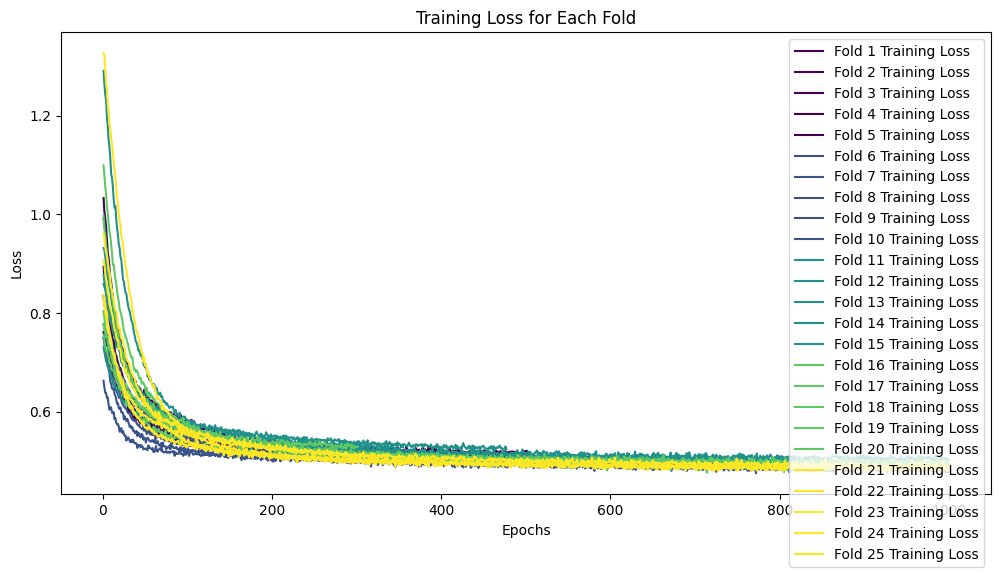

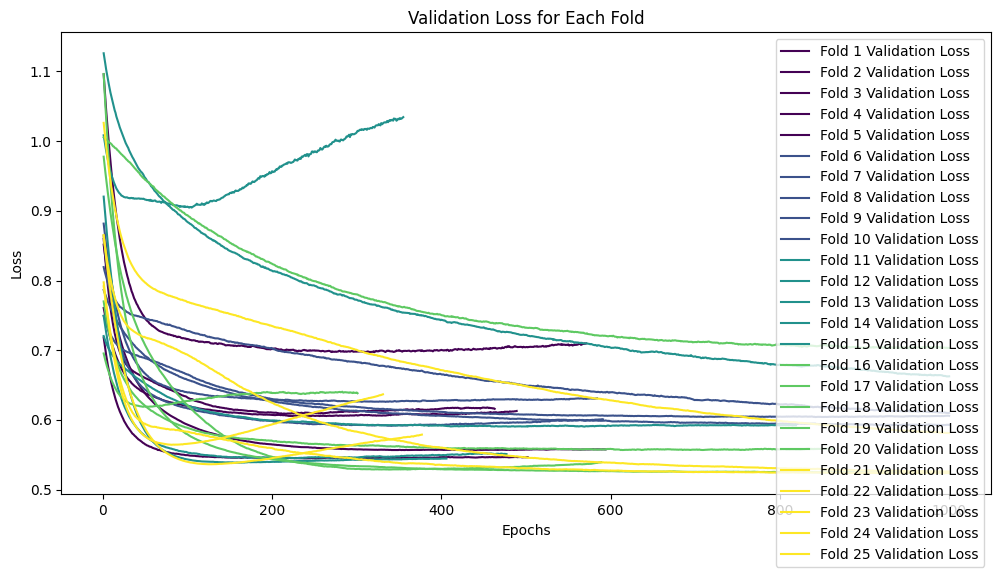

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_val_loss.svg")
plt.show()